In [382]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [383]:
df_full = pd.read_csv('data2.csv', index_col=0)
label_cols = [c for c in df_full.columns if 'genre_' in c]
df_full['genre_other'] = (df_full[label_cols].sum(axis=1) < 1).astype(int)
print('genres: ', [c.replace('genre_', '') for c in label_cols])

genres:  ['black', 'death', 'doom', 'folk', 'heavy', 'melodic', 'power', 'progressive', 'rock', 'technical', 'thrash']


In [4]:
def avg_word_len(row):
    words = list(row[row > 0].index)
    return sum(len(word) * row[word] for word in words) / len(words)

# df_full.apply(avg_word_len, axis=1).sort_values()

In [400]:
def df_to_Xy(df_full, genre, reduce_features=False, normalize=False, oversampler=None, logX=True, random_state=0):
    genre_col = 'genre_' + genre
    feature_cols = [c for c in df_full.columns if 'genre_' not in c]
    if reduce_features:
        feature_cols = list(np.array(feature_cols)[(df_full[feature_cols] > 10).any(axis=0)])
    df = df_full[feature_cols + [genre_col]]
    df_features = df[feature_cols].copy()
    if normalize:
        df = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df[genre_col]), axis=1)
    X = df[feature_cols].values
    if logX:
        X = np.log1p(X)
    y = df['genre_' + genre].values
    if oversampler:
        X, y = oversampler(random_state=random_state).fit_resample(X, y)
    return X, y, feature_cols

    
def Xy_to_split(X, y, scale=False, reduce_features=False, test_size=0.2, pca=None, random_state=0, verbose=False):
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    if pca:
        X = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    if reduce_features:
        train_idx = np.flatnonzero(X_train.sum(axis=0) > 0)
        X_train = X_train[:, train_idx]
        X_test = X_test[:, train_idx]
    if verbose:
        print(sum(y == 0), sum(y == 1))
        print(sum(y_train == 0), sum(y_train == 1))
        print(sum(y_test == 0), sum(y_test == 1))
    return X_train, X_test, y_train, y_test

In [384]:
genre = 'black'

In [385]:
feature_cols = [c for c in df_full.columns if 'genre_' not in c]
# Feature reduction
# feature_cols = list(np.array(feature_cols)[(df_full[feature_cols] < 10).any(axis=0)])
feature_cols = list(np.array(feature_cols)[(df_full[feature_cols].sum(axis=0) > 100)])

genre_col = 'genre_' + genre
df = df_full[feature_cols + [genre_col]]
df_features = df[feature_cols].copy()
df = pd.concat((df_features.div(df_features.sum(axis=1), axis=0), df[genre_col]), axis=1)
# df.head()
df.shape

(386, 2165)

In [396]:
X, y, feature_cols = df_to_Xy(df_full, genre, reduce_features=False, normalize=False, logX=True)

In [376]:
corr = df.corr()
# corr_cols = corr.columns[corr[genre_col].abs() > 0.1]
# corr_cols = corr[genre_col].abs().sort_values(ascending=False).index[:100]
corr_cols = corr[genre_col].sort_values(ascending=False).index[:20]
corr = corr.loc[corr_cols, corr_cols]
corr_sort = corr[genre_col].argsort()
corr = corr.iloc[corr_sort, corr_sort]

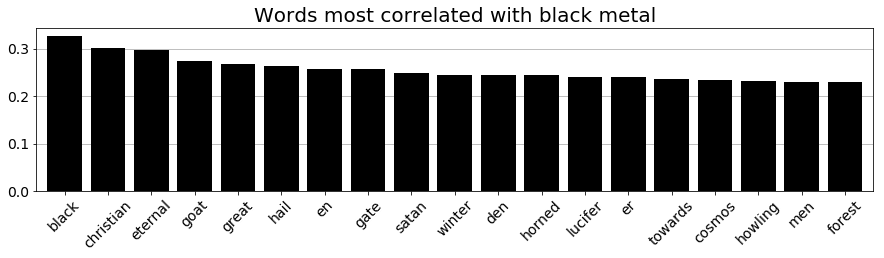

In [377]:
plt.figure(figsize=(15, 3))
corr[genre_col][-2::-1].plot(kind='bar', color='k', width=0.8)
plt.title('Words most correlated with {} metal'.format(genre), size=20)
plt.tick_params(labelsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.gca().set_axisbelow(True)
plt.show()

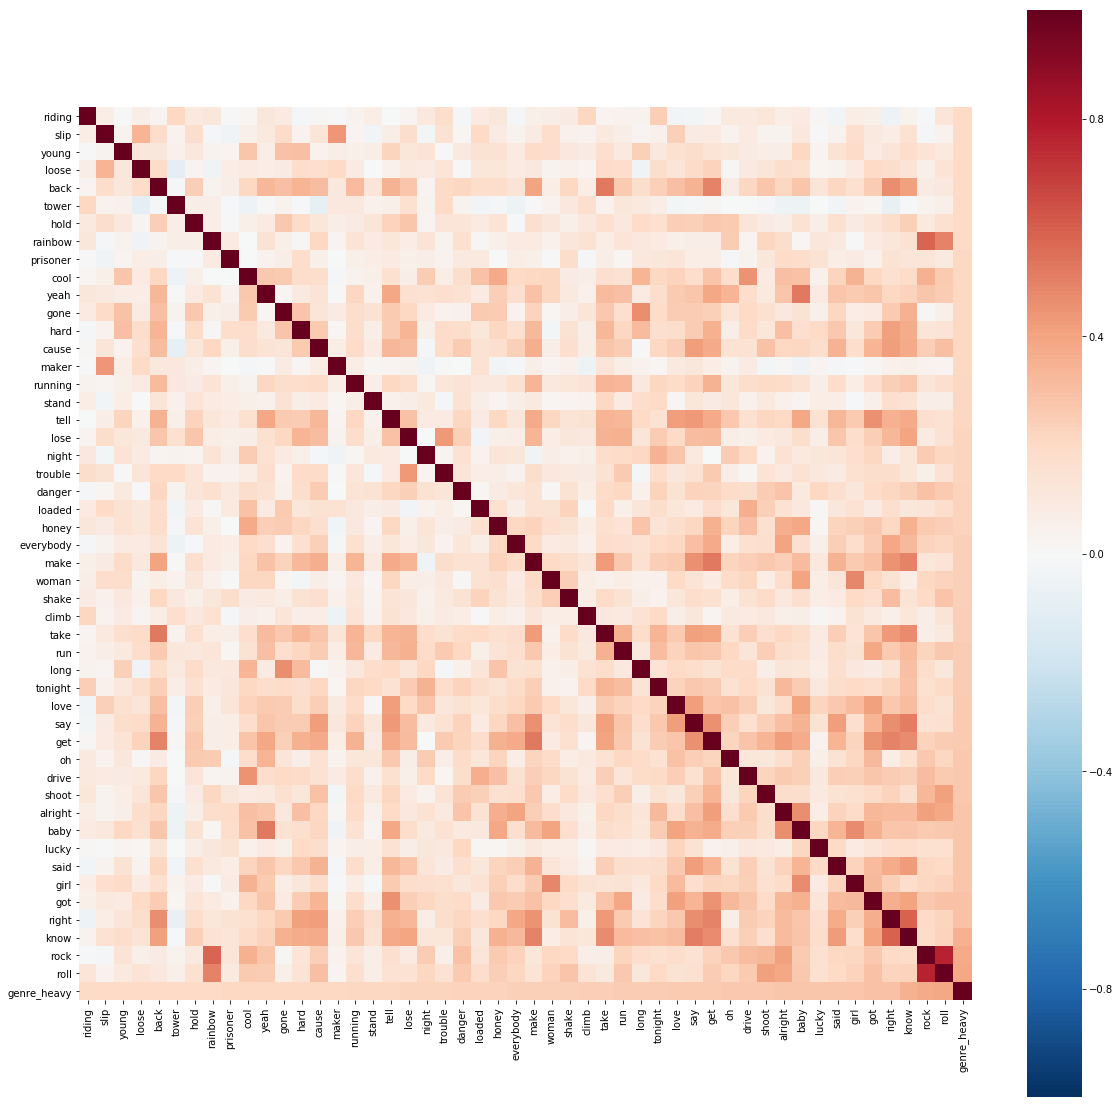

In [214]:
plt.figure(figsize=(20, 20))
sns.heatmap(corr, square=True, cmap=plt.cm.RdBu_r, center=0, vmin=-1, vmax=1)
plt.show()

In [422]:
# X = df[feature_cols].values
# X = np.log1p(X)
# y = df['genre_' + genre].values

# # Oversampling
# # if oversample:
# # X, y = RandomOverSampler(random_state=0).fit_resample(X, y)
# # X, y = SMOTE(random_state=0).fit_resample(X, y)
# # X, y = BorderlineSMOTE(random_state=0).fit_resample(X, y)
# X, y = SVMSMOTE(random_state=0).fit_resample(X, y)
# # X, y = ADASYN(random_state=0).fit_resample(X, y)

# print(sum(y == 0), sum(y == 1))

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# train_idx = np.flatnonzero(X_train.sum(axis=0) > 0)
# X_train = X_train[:, train_idx]
# X_test = X_test[:, train_idx]
# print(sum(y_train == 0), sum(y_train == 1))
# print(sum(y_test == 0), sum(y_test == 1))

## Logistic regression
* Oversampling method: SVMSMOTE, BorderlineSMOTE, RandomOverSampler; not very sensitive to choice
* PCA: no effect

In [398]:
X, y, feature_cols = df_to_Xy(df_full, genre, reduce_features=False, normalize=False, oversampler=SVMSMOTE, logX=True)
X_train, X_test, y_train, y_test = Xy_to_split(X, y, scale=False, test_size=0.2, random_state=0)
model = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
cvscore = cross_val_score(model, X, y, cv=5)

print('cross-validation scores:', cvscore)
print('cross-validation mean and 95% conf interval: {:.4f} +/- {:.4f}'.format(cvscore.mean(), 2 * cvscore.std()))
print('accuracy on training data: {:.4f}'.format(accuracy_score(y_train, y_train_pred)))
print('accuracy on test data: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('classification report:\n', classification_report(y_test, y_pred))
print('confusion matrix:\n', confusion_matrix(y_test, y_pred))

cross-validation scores: [0.89090909 0.92727273 0.9        0.93636364 0.94545455]
cross-validation mean and 95% conf interval: 0.9200 +/- 0.0421
accuracy on training data: 1.0000
accuracy on test data: 0.9273
classification report:
               precision    recall  f1-score   support

           0       0.97      0.85      0.91        46
           1       0.90      0.98      0.94        64

    accuracy                           0.93       110
   macro avg       0.94      0.92      0.92       110
weighted avg       0.93      0.93      0.93       110

confusion matrix:
 [[39  7]
 [ 1 63]]


In [424]:
model = LogisticRegression(solver='lbfgs', random_state=0)
y_pred = cross_val_predict(model, X, y, cv=10, n_jobs=-1)
cvscore = cross_val_score(model, X, y, cv=10, n_jobs=-1)

print('cross-validation scores:', cvscore)
print('cross-validation mean and 95% conf interval: {:.4f} +/- {:.4f}'.format(cvscore.mean(), 2 * cvscore.std()))
print('accuracy on test data: {:.4f}'.format(accuracy_score(y, y_pred)))
# print('classification report:\n', classification_report(y, y_pred))
print('confusion matrix:\n', confusion_matrix(y, y_pred))

cross-validation scores: [0.725      0.75       0.8974359  0.74358974 0.84210526 0.73684211
 0.84210526 0.73684211 0.84210526 0.78947368]
cross-validation mean and 95% conf interval: 0.7905 +/- 0.1154
accuracy on test data: 0.7902
confusion matrix:
 [[219  25]
 [ 56  86]]


## Random forest
* Oversampling method: RandomOverSampler, SVMSMOTE

In [414]:
X, y, feature_cols = df_to_Xy(df_full, genre, reduce_features=False, normalize=False, oversampler=RandomOverSampler, logX=True)
X_train, X_test, y_train, y_test = Xy_to_split(X, y, scale=False, test_size=0.2)
model = RandomForestClassifier(n_estimators=100, max_depth=30, min_samples_split=2, min_samples_leaf=2, n_jobs=-1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
cvscore = cross_val_score(model, X, y, cv=5)

print('cross-validation scores:', cvscore)
print('cross-validation mean and 95% conf interval: {:.4f} +/- {:.4f}'.format(cvscore.mean(), 2 * cvscore.std()))
print('accuracy on training data: {:.4f}'.format(accuracy_score(y_train, y_train_pred)))
print('accuracy on test data: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('classification report:\n', classification_report(y_test, y_pred))
print('confusion matrix:\n', confusion_matrix(y_test, y_pred))

cross-validation scores: [0.95454545 0.87272727 0.90909091 0.94545455 0.93636364]
cross-validation mean and 95% conf interval: 0.9236 +/- 0.0593
accuracy on training data: 0.9955
accuracy on test data: 0.8636
classification report:
               precision    recall  f1-score   support

           0       0.83      0.85      0.84        46
           1       0.89      0.88      0.88        64

    accuracy                           0.86       110
   macro avg       0.86      0.86      0.86       110
weighted avg       0.86      0.86      0.86       110

confusion matrix:
 [[39  7]
 [ 8 56]]


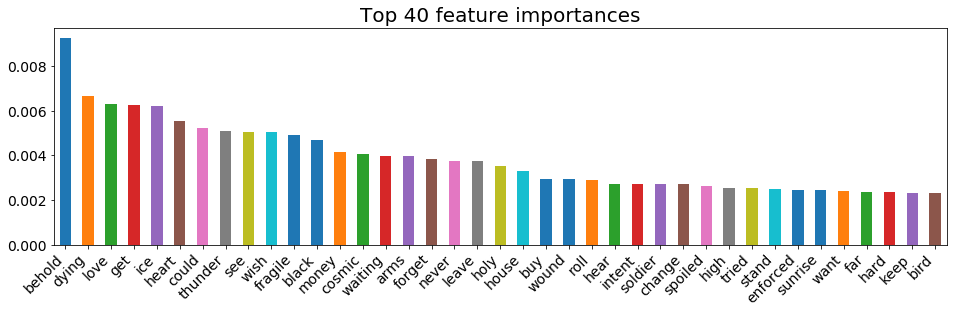

In [333]:
feature_importances = pd.Series(model.feature_importances_, index=feature_cols)
plt.figure(figsize=(16, 4))
feature_importances.sort_values()[:-40:-1].plot(kind='bar')
plt.title("Top 40 feature importances", size=20)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.show()

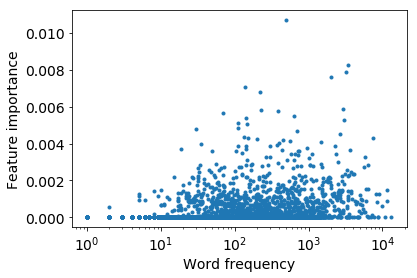

In [427]:
plt.plot(df[feature_cols].sum(axis=0), feature_importances, '.')
plt.xlabel("Word frequency", size=14)
plt.ylabel("Feature importance", size=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xscale('log')
# plt.yscale('log')
plt.show()

## Naive Bayes
#### Bernoulli
* Oversampling method: SVMSMOTE, ADASYN

In [454]:
model = BernoulliNB()
for reduce_features in [True, False]:
    print('Feature reduction: ', reduce_features)
    for normalize in [True, False]:
        print('Normalize: ', normalize)
        for sampler in [None, RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN]:
            X, y = df_to_Xy(df_full, genre, reduce_features=reduce_features, normalize=normalize, oversampler=sampler, logX=True, random_state=0)
            X_train, X_test, y_train, y_test = Xy_to_split(X, y, scale=False, test_size=0.2, random_state=0)
            cvscore = cross_val_score(model, X, y, cv=5)
            name = sampler.__name__ if sampler else 'No oversampling'
            print('{}: \t\t{:.4f} +/- {:.4f}'.format(name, cvscore.mean(), 2 * cvscore.std()))
        print()
    print('---')

Feature reduction:  True
Normalize:  True
No oversampling: 		0.7281 +/- 0.0508
RandomOverSampler: 		0.7891 +/- 0.0593
SMOTE: 		0.6852 +/- 0.2903
BorderlineSMOTE: 		0.6648 +/- 0.2901
SVMSMOTE: 		0.6781 +/- 0.1739
ADASYN: 		0.6775 +/- 0.2871

Normalize:  False
No oversampling: 		0.7281 +/- 0.0508
RandomOverSampler: 		0.7891 +/- 0.0593
SMOTE: 		0.6993 +/- 0.1950
BorderlineSMOTE: 		0.7056 +/- 0.1803
SVMSMOTE: 		0.7343 +/- 0.1782
ADASYN: 		0.6990 +/- 0.1190

---
Feature reduction:  False
Normalize:  True
No oversampling: 		0.7177 +/- 0.0662
RandomOverSampler: 		0.7584 +/- 0.0630
SMOTE: 		0.7468 +/- 0.3458
BorderlineSMOTE: 		0.7303 +/- 0.3132
SVMSMOTE: 		0.7048 +/- 0.2202
ADASYN: 		0.7336 +/- 0.3182

Normalize:  False
No oversampling: 		0.7177 +/- 0.0662
RandomOverSampler: 		0.7584 +/- 0.0630
SMOTE: 		0.7383 +/- 0.2078
BorderlineSMOTE: 		0.7484 +/- 0.1589
SVMSMOTE: 		0.7446 +/- 0.1889
ADASYN: 		0.7622 +/- 0.1331

---


In [428]:
X, y = df_to_Xy(df_full, genre, reduce_features=False, normalize=False, logX=True)
X_train, X_test, y_train, y_test = Xy_to_split(X, y, oversampler=SVMSMOTE, scale=False, test_size=0.2, random_state=0)
model = BernoulliNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
cvscore = cross_val_score(model, X, y, cv=5)

print('cross-validation scores:', cvscore)
print('cross-validation mean and 95% conf interval: {:.4f} +/- {:.4f}'.format(cvscore.mean(), 2 * cvscore.std()))
print('accuracy on training data: {:.4f}'.format(accuracy_score(y_train, y_train_pred)))
print('accuracy on test data: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('classification report:\n', classification_report(y_test, y_pred))
print('confusion matrix:\n', confusion_matrix(y_test, y_pred))

244 244
198 192
46 52
cross-validation scores: [0.67948718 0.74358974 0.74025974 0.67532468 0.75      ]
cross-validation mean and 95% conf interval: 0.7177 +/- 0.0662
accuracy on training data: 0.8256
accuracy on test data: 0.7143
classification report:
               precision    recall  f1-score   support

           0       0.65      0.87      0.74        46
           1       0.83      0.58      0.68        52

    accuracy                           0.71        98
   macro avg       0.74      0.72      0.71        98
weighted avg       0.75      0.71      0.71        98

confusion matrix:
 [[40  6]
 [22 30]]


#### Gaussian
* Oversampling method: ADASYN, SVMSMOTE

In [452]:
model = GaussianNB()
for reduce_features in [True, False]:
    print('Feature reduction: ', reduce_features)
    for normalize in [True, False]:
        print('Normalize: ', normalize)
        for sampler in [None, RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN]:
            X, y = df_to_Xy(df_full, genre, reduce_features=reduce_features, normalize=normalize, oversampler=sampler, logX=True, random_state=0)
            X_train, X_test, y_train, y_test = Xy_to_split(X, y, scale=True, test_size=0.2, random_state=0)
            cvscore = cross_val_score(model, X, y, cv=5)
            name = sampler.__name__ if sampler else 'No oversampling'
            print('{}: \t\t{:.4f} +/- {:.4f}'.format(name, cvscore.mean(), 2 * cvscore.std()))
        print()
    print('---')

Feature reduction:  True
Normalize:  True
No oversampling: 		0.5776 +/- 0.0838
RandomOverSampler: 		0.7010 +/- 0.1090
SMOTE: 		0.7276 +/- 0.0954
BorderlineSMOTE: 		0.7256 +/- 0.0878
SVMSMOTE: 		0.7418 +/- 0.0939
ADASYN: 		0.7496 +/- 0.0857

Normalize:  False
No oversampling: 		0.5389 +/- 0.0996
RandomOverSampler: 		0.6847 +/- 0.1193
SMOTE: 		0.6989 +/- 0.0952
BorderlineSMOTE: 		0.6887 +/- 0.1175
SVMSMOTE: 		0.6928 +/- 0.0974
ADASYN: 		0.6907 +/- 0.1072

---
Feature reduction:  False
Normalize:  True
No oversampling: 		0.6737 +/- 0.0639
RandomOverSampler: 		0.7768 +/- 0.1418
SMOTE: 		0.8034 +/- 0.1046
BorderlineSMOTE: 		0.8054 +/- 0.0983
SVMSMOTE: 		0.8054 +/- 0.0966
ADASYN: 		0.8279 +/- 0.0688

Normalize:  False
No oversampling: 		0.6785 +/- 0.0710
RandomOverSampler: 		0.7892 +/- 0.1347
SMOTE: 		0.8116 +/- 0.1037
BorderlineSMOTE: 		0.8177 +/- 0.0871
SVMSMOTE: 		0.8034 +/- 0.1148
ADASYN: 		0.8288 +/- 0.0784

---


In [449]:
X, y = df_to_Xy(df_full, genre, reduce_features=False, normalize=False, oversampler=ADASYN, logX=True, random_state=0)
X_train, X_test, y_train, y_test = Xy_to_split(X, y, scale=True, test_size=0.2, random_state=0)
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)
cvscore = cross_val_score(model, X, y, cv=5)

print('cross-validation scores:', cvscore)
print('cross-validation mean and 95% conf interval: {:.4f} +/- {:.4f}'.format(cvscore.mean(), 2 * cvscore.std()))
print('accuracy on training data: {:.4f}'.format(accuracy_score(y_train, y_train_pred)))
print('accuracy on test data: {:.4f}'.format(accuracy_score(y_test, y_pred)))
print('classification report:\n', classification_report(y_test, y_pred))
print('confusion matrix:\n', confusion_matrix(y_test, y_pred))

cross-validation scores: [0.86458333 0.76041667 0.8125     0.86458333 0.84210526]
cross-validation mean and 95% conf interval: 0.8288 +/- 0.0784
accuracy on training data: 0.9974
accuracy on test data: 0.7500
classification report:
               precision    recall  f1-score   support

           0       0.82      0.66      0.73        50
           1       0.70      0.85      0.76        46

    accuracy                           0.75        96
   macro avg       0.76      0.75      0.75        96
weighted avg       0.76      0.75      0.75        96

confusion matrix:
 [[33 17]
 [ 7 39]]
